# Домашняя работа №3

При отправлении ДЗ в Dropbox указывайте фамилию в названии файла: <br\>
** IDA<Номер группы>HW3<Фамилия>.ipynb ** - например ** IDA3HW3Pupkin.ipynb **<br\>


Используйте данный Ipython Notebook при оформлении домашнего задания.

# Преамбула

Автоэнкодеры - это полносвязные сети, задачей которых является на выходе сети восстановить объекты, поданные на вход. Такие сети состоят из двух частей - енкодера и декодера. В каждом следующем слое энкодера становится всё меньше и меньше нейронов, в результате чего происходит "сжатие" исходной информации. В самом сжатом виде информация находится на последнем слое энкодера который называется bottleneck(с англ. бутылочное горлышко). Далее информация из bottleneck'a подаётся на вход декодеру, у которого наоборот с каждый следующим слоем количество нейронов становится больше и больше. Размерности выходов и входов такой нейронной сети совпадают. 

<img src="autoencoder.png">

Активации нейронов с самого узкого слоя можно использовать как довольно качественные признаки для передачи в другие модели машинного обучения.

Целью данного домашнего задания является реализация нескольких вариантов автокодировщиков, проведение экспериментов с целью определения структур, которые выучивают нейроны. 

In [1]:
import numpy as np

import keras

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


# Загрузка и предобработка данных(2.5 балла).

Загрузите *images.pkl*. Данный файл содержит набор фото. 

In [2]:
import pickle as pkl

images = np.load(open('images.npy', 'br'))

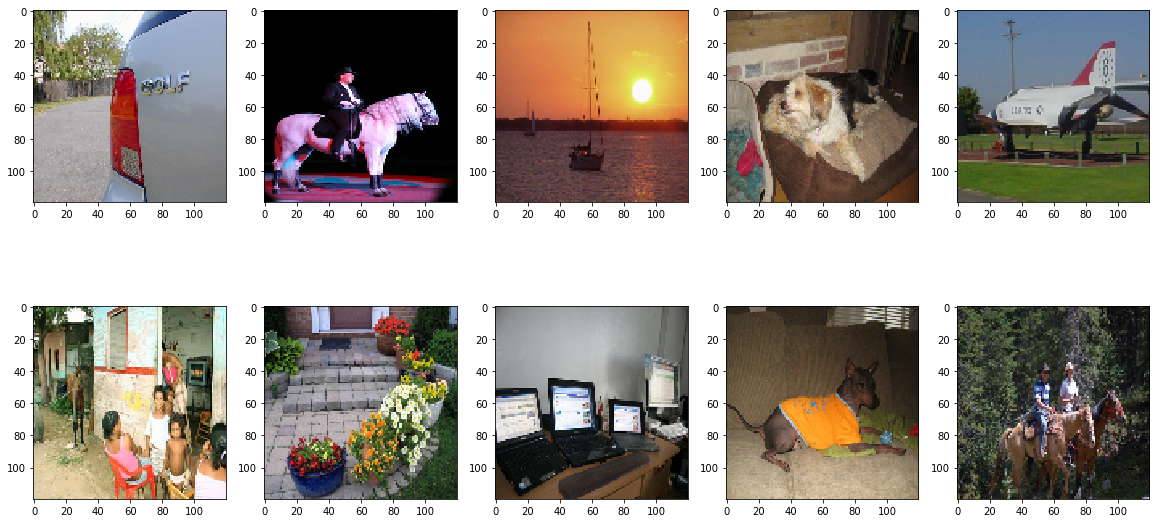

In [3]:
plt.figure(figsize=(20, 10))

for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i])

## Генерация датасета(2 балла)

Напишите функцию, которая принимает на вход исходный набор фотографий из возращает нужное количество "сэмплов" - случайных квадратных подкартинок нужного размера. Визуализируйте несколько сэмплов.

In [4]:
def get_samples(full_images, num_samples=10000, sample_size=16, rand_seed=123):
    # входные параметры
    # full_images: np.array, исходный датасет
    # num_samples: int, количество патчей, которые функция должна вернуть
    # sample_size: int, длина стороны каждого патча
    # rand_seed: int, число для инициализации np.random.seed, чтобы генерация датасета была воспроизводимой
    np.random.seed(rand_seed)
    i = np.random.randint(0, full_images.shape[1] - sample_size)
    j = np.random.randint(0, full_images.shape[2] - sample_size)
    return np.asarray([gg[i:i+sample_size, j:j+sample_size] for gg in full_images[np.random.randint(0, full_images.shape[0], num_samples)]])
    # выход функции
    # np.array размера [num_samples, sample_size, sample_size, 3]
    #pass

In [5]:
pikchi = get_samples(images)

In [6]:
pikchi.shape

(10000, 16, 16, 3)

In [7]:
def show_pics(imgs, col, row):
    fig = plt.figure(figsize=(2*col,2*row))
    for i in range(0, col*row ):
        fig.add_subplot(row, col, i + 1)
        plt.imshow(imgs[i])


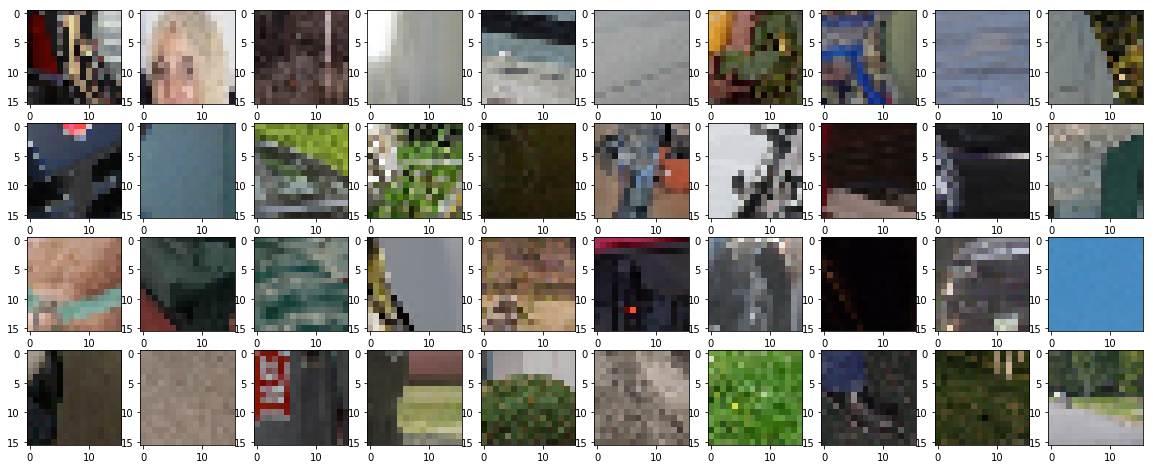

In [8]:
show_pics(pikchi, 10, 4)

## Нормировка картинок и вытягивание их в один вектор(0.5 балл)

Переведите интенсивности каждого канала (R, G, B) в отрезок $[0.1, 0.9]$. Значения отбрасывать не надо, просто отшкалируйте каналы.

In [9]:
for i in [0, 1, 2]:
    pikchi[:, :, :, i] = (pikchi[:, :, :, i] - pikchi[:, :, :, i].min())*((0.9 - 0.1)/(pikchi[:, :, :, i].max() - pikchi[:, :, :, i].min())) + 0.1 

Преобразуйте каждый семпл-матрицу в вектор.

То есть из исходного набора сэмплов размера [num_samples, sample_size, sample_size, 3] должен получиться набор размера [num_samples, sample_size x sample_size x 3].

In [10]:
pikchi.shape

(10000, 16, 16, 3)

In [11]:
pikchi = pikchi.reshape((len(pikchi),np.prod(pikchi.shape[1:])))

In [12]:
pikchi.shape

(10000, 768)

# Реализация и обучение автокодировщика(4 балла)

### Построение автокодировщика(1.5 балла)

Напишите функцию, которая принимает параметры автокодировщика(размер входа и выхода, количества нейронов в каждом слое энкодера, количество нейронов в каждом слое декодера). Внутри автокодировщика использовать нелинейности-RELU. Но для выходов автоэнкодера использовать сигмоиду.

Выход функции - Keras модель, скомпилированная чтобы минимизировать MSE на трэйне. Оптимизатор - на ваш выбор.

In [13]:
from keras.models import Model, Sequential
from keras.layers import Input, Dense

In [14]:
def create_autoencoder_model(object_size=768, encoder_layer_shapes=[256, 144, 64], decoder_layer_shapes=[200, 400]):
    # входные параметры:
    # object_size: int, размер входного и выходного слоя автоэнкодера
    # encoder_layer_shapes: list of int, количество нейронов в каждом слое энкодера. 
    #                       последний элемент списка - размер "бутылочного горлышка"
    # decoder_layer_shapes: list of int, количество нейронов в каждом слое декодера
    input_img = Input(shape=(object_size,))
    
    encoded = Dense(encoder_layer_shapes[0], activation='relu')(input_img)
    
    for i in encoder_layer_shapes[1:]:
        encoded = Dense(i, activation='relu')(encoded)
    
    decoded = Dense(decoder_layer_shapes[0], activation='relu')(encoded)
    
    for i in decoder_layer_shapes[1:len(decoder_layer_shapes)]:
        decoded = Dense(i, activation='relu')(decoded)
    
    decoded = Dense(object_size, activation='sigmoid')(decoded)
    # выход:
    # keras модель
    model = Model(input_img, decoded)
    return model

Разделите выборку из сэмплов на тренировочную выборку и валидационную отношении 90%-10%.

In [15]:
autoencoder = create_autoencoder_model()
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 768)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               196864    
_________________________________________________________________
dense_2 (Dense)              (None, 144)               37008     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                9280      
_________________________________________________________________
dense_4 (Dense)              (None, 200)               13000     
_________________________________________________________________
dense_5 (Dense)              (None, 400)               80400     
_________________________________________________________________
dense_6 (Dense)              (None, 768)               307968    
Total para

In [16]:
from sklearn.model_selection import train_test_split
x_train, x_test = train_test_split(pikchi, test_size=0.1, random_state=123)

In [17]:
autoencoder.compile(loss='mean_squared_error',
              optimizer='adam')
hist = autoencoder.fit(x_train, x_train,
          batch_size=64,
          epochs=100,
          validation_data=(x_test, x_test))

Train on 9000 samples, validate on 1000 samples
Epoch 1/100
9000/9000 [==============================] - 5s 514us/step - loss: 0.0259 - val_loss: 0.0140
Epoch 2/100
9000/9000 [==============================] - 3s 381us/step - loss: 0.0119 - val_loss: 0.0111
Epoch 3/100
9000/9000 [==============================] - 4s 477us/step - loss: 0.0103 - val_loss: 0.0100
Epoch 4/100
9000/9000 [==============================] - 6s 632us/step - loss: 0.0094 - val_loss: 0.0093
Epoch 5/100
9000/9000 [==============================] - 4s 392us/step - loss: 0.0089 - val_loss: 0.0088
Epoch 6/100
9000/9000 [==============================] - 5s 602us/step - loss: 0.0085 - val_loss: 0.0084
Epoch 7/100
9000/9000 [==============================] - 3s 312us/step - loss: 0.0081 - val_loss: 0.0083
Epoch 8/100
9000/9000 [==============================] - 5s 512us/step - loss: 0.0078 - val_loss: 0.0082
Epoch 9/100
9000/9000 [==============================] - 3s 349us/step - loss: 0.0076 - val_loss: 0.0076
Epoch 1

In [18]:
score = autoencoder.evaluate(x_test, x_test, verbose=0)
print('mse on validation:', score)

mse on validation: 0.00455651915073


Обучите модель со стандартными параметрами.

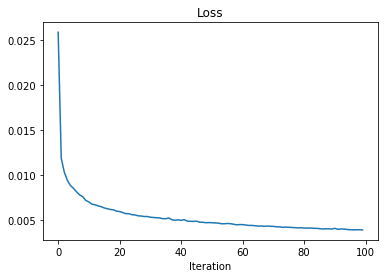

In [19]:
plt.title('Loss')
plt.xlabel('Iteration')
plt.plot(hist.history['loss'])

### Визуализация паттернов, которые находят нейроны(1.5 балла)

Возьмите несколько объектов из валидационной выборки и прогоните через автоэнкодер. Оцените визуально результат восстановления объектов.

In [20]:
x_pred = autoencoder.predict(x_test[:7])
x_pred = x_pred.reshape((len(x_pred), 16, 16, 3))

In [21]:
tmp = np.copy(x_test[:7].reshape(7, 16, 16, 3))

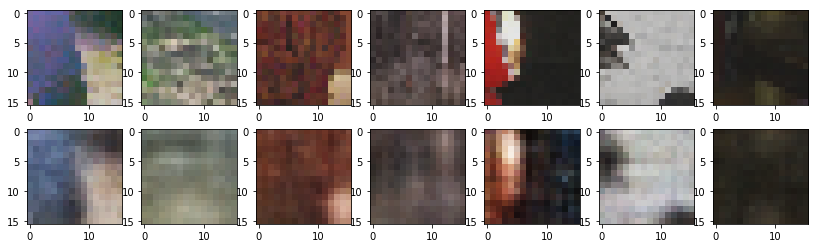

In [22]:
show_pics(np.concatenate((tmp, x_pred)), 7, 2)

Для каждого слоя и для каждого нейрона на этом слое найдите объект из тренировочной выборки, на котором этот нейрон выдаёт наибольшую активацию. Если нейрон ни на одном объекте не активировался, пропустите изображение для него. Что можете сказать про сложность шаблонов на объектах для каждого слоя?

In [23]:
# чекним как это ваще работает
intermediate_layer_model = Model(inputs=autoencoder.input,
                                 outputs=autoencoder.layers[1].output)
intermediate_output = intermediate_layer_model.predict(x_train)

In [24]:
# тэкс, понятненько
intermediate_output.shape

(9000, 256)

In [25]:
np.argmax(intermediate_output[:, 1])

0

In [26]:
# для первого слоя
# идем по всем нейронам и выбираем обьект из выборки с наибольшей активацией
activations = [np.argmax(intermediate_output[:, i]) for i in range(0, intermediate_output.shape[1])]

In [27]:
print(activations)

[0, 0, 0, 0, 0, 7415, 536, 0, 0, 0, 0, 5004, 7064, 3443, 0, 0, 1001, 3971, 3952, 0, 1234, 1384, 6943, 0, 0, 0, 0, 8101, 0, 0, 697, 0, 0, 1278, 8806, 0, 0, 2695, 0, 4204, 0, 0, 0, 5178, 277, 0, 131, 0, 528, 5207, 1278, 0, 0, 0, 0, 2427, 0, 880, 0, 7825, 156, 0, 0, 0, 0, 0, 0, 7649, 2320, 0, 0, 6551, 6300, 0, 2147, 0, 4829, 0, 0, 0, 3270, 3466, 0, 0, 0, 3449, 0, 0, 0, 0, 1050, 0, 0, 3396, 6411, 0, 2750, 0, 0, 1234, 8101, 0, 0, 0, 0, 0, 6862, 870, 0, 0, 4398, 2695, 6401, 1001, 0, 0, 2687, 1384, 3479, 0, 0, 983, 2149, 0, 0, 0, 2078, 0, 0, 961, 0, 0, 0, 0, 2689, 0, 7773, 0, 3801, 0, 0, 1223, 0, 0, 0, 0, 0, 0, 0, 2187, 0, 0, 0, 0, 1399, 0, 2576, 0, 0, 0, 0, 0, 0, 0, 0, 0, 277, 0, 0, 0, 0, 8606, 5394, 0, 0, 0, 0, 0, 0, 0, 0, 4334, 0, 2871, 4398, 0, 4121, 0, 3208, 0, 0, 3671, 0, 0, 0, 0, 0, 0, 3324, 1278, 8756, 0, 0, 5178, 0, 0, 6108, 4138, 0, 0, 0, 0, 0, 1278, 8101, 2243, 3449, 2427, 2972, 0, 8909, 7660, 1001, 0, 0, 0, 1223, 0, 3284, 880, 0, 593, 5018, 6523, 3877, 0, 0, 1419, 0, 0, 0, 0, 0, 6

In [51]:
activations = []
for i in range(len(autoencoder.layers)):
    intermediate_layer_model = Model(inputs=autoencoder.input,
                                 outputs=autoencoder.layers[i].output)
    intermediate_output = intermediate_layer_model.predict(x_train)
    activations.append([np.argmax(intermediate_output[:, j]) for j in range(0, intermediate_output.shape[1])])
   

In [52]:
for i in range(1, len(activations)):
    print('layer #', i)
    print('-------------------------------------------------------------------------------------------------------')
    print(activations[i])

layer # 1
-------------------------------------------------------------------------------------------------------
[0, 0, 0, 0, 0, 7415, 536, 0, 0, 0, 0, 5004, 7064, 3443, 0, 0, 1001, 3971, 3952, 0, 1234, 1384, 6943, 0, 0, 0, 0, 8101, 0, 0, 697, 0, 0, 1278, 8806, 0, 0, 2695, 0, 4204, 0, 0, 0, 5178, 277, 0, 131, 0, 528, 5207, 1278, 0, 0, 0, 0, 2427, 0, 880, 0, 7825, 156, 0, 0, 0, 0, 0, 0, 7649, 2320, 0, 0, 6551, 6300, 0, 2147, 0, 4829, 0, 0, 0, 3270, 3466, 0, 0, 0, 3449, 0, 0, 0, 0, 1050, 0, 0, 3396, 6411, 0, 2750, 0, 0, 1234, 8101, 0, 0, 0, 0, 0, 6862, 870, 0, 0, 4398, 2695, 6401, 1001, 0, 0, 2687, 1384, 3479, 0, 0, 983, 2149, 0, 0, 0, 2078, 0, 0, 961, 0, 0, 0, 0, 2689, 0, 7773, 0, 3801, 0, 0, 1223, 0, 0, 0, 0, 0, 0, 0, 2187, 0, 0, 0, 0, 1399, 0, 2576, 0, 0, 0, 0, 0, 0, 0, 0, 0, 277, 0, 0, 0, 0, 8606, 5394, 0, 0, 0, 0, 0, 0, 0, 0, 4334, 0, 2871, 4398, 0, 4121, 0, 3208, 0, 0, 3671, 0, 0, 0, 0, 0, 0, 3324, 1278, 8756, 0, 0, 5178, 0, 0, 6108, 4138, 0, 0, 0, 0, 0, 1278, 8101, 2243, 3449, 24

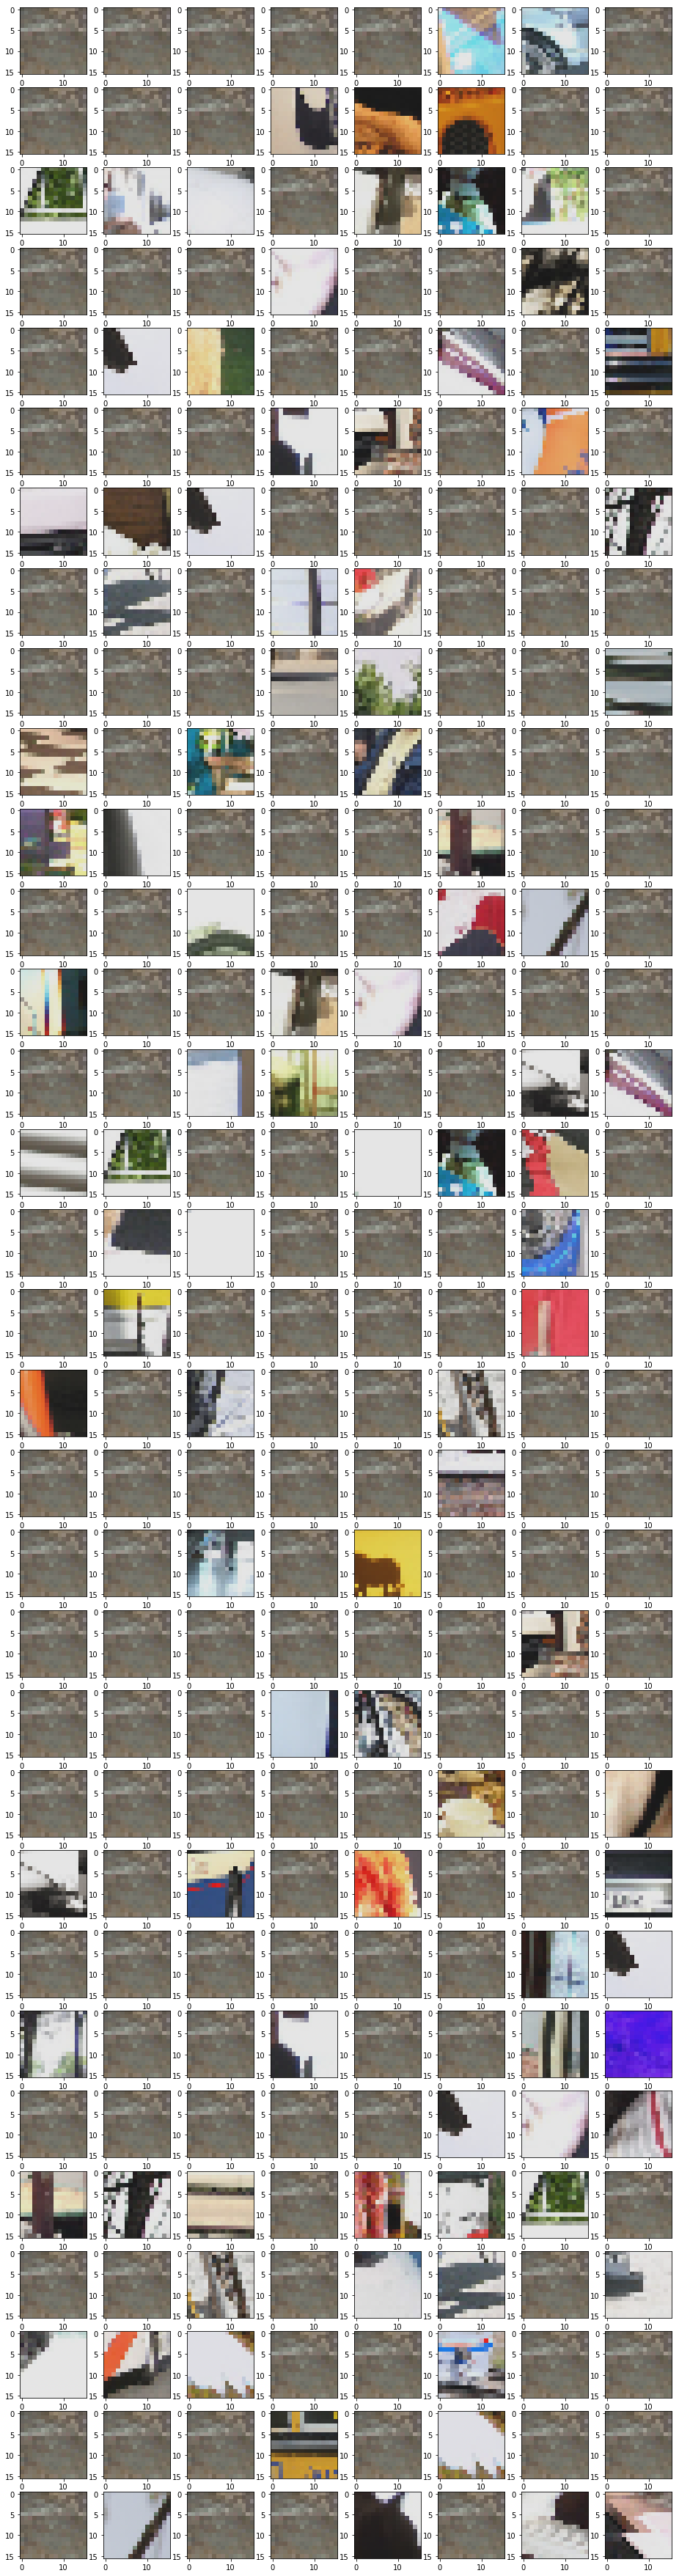

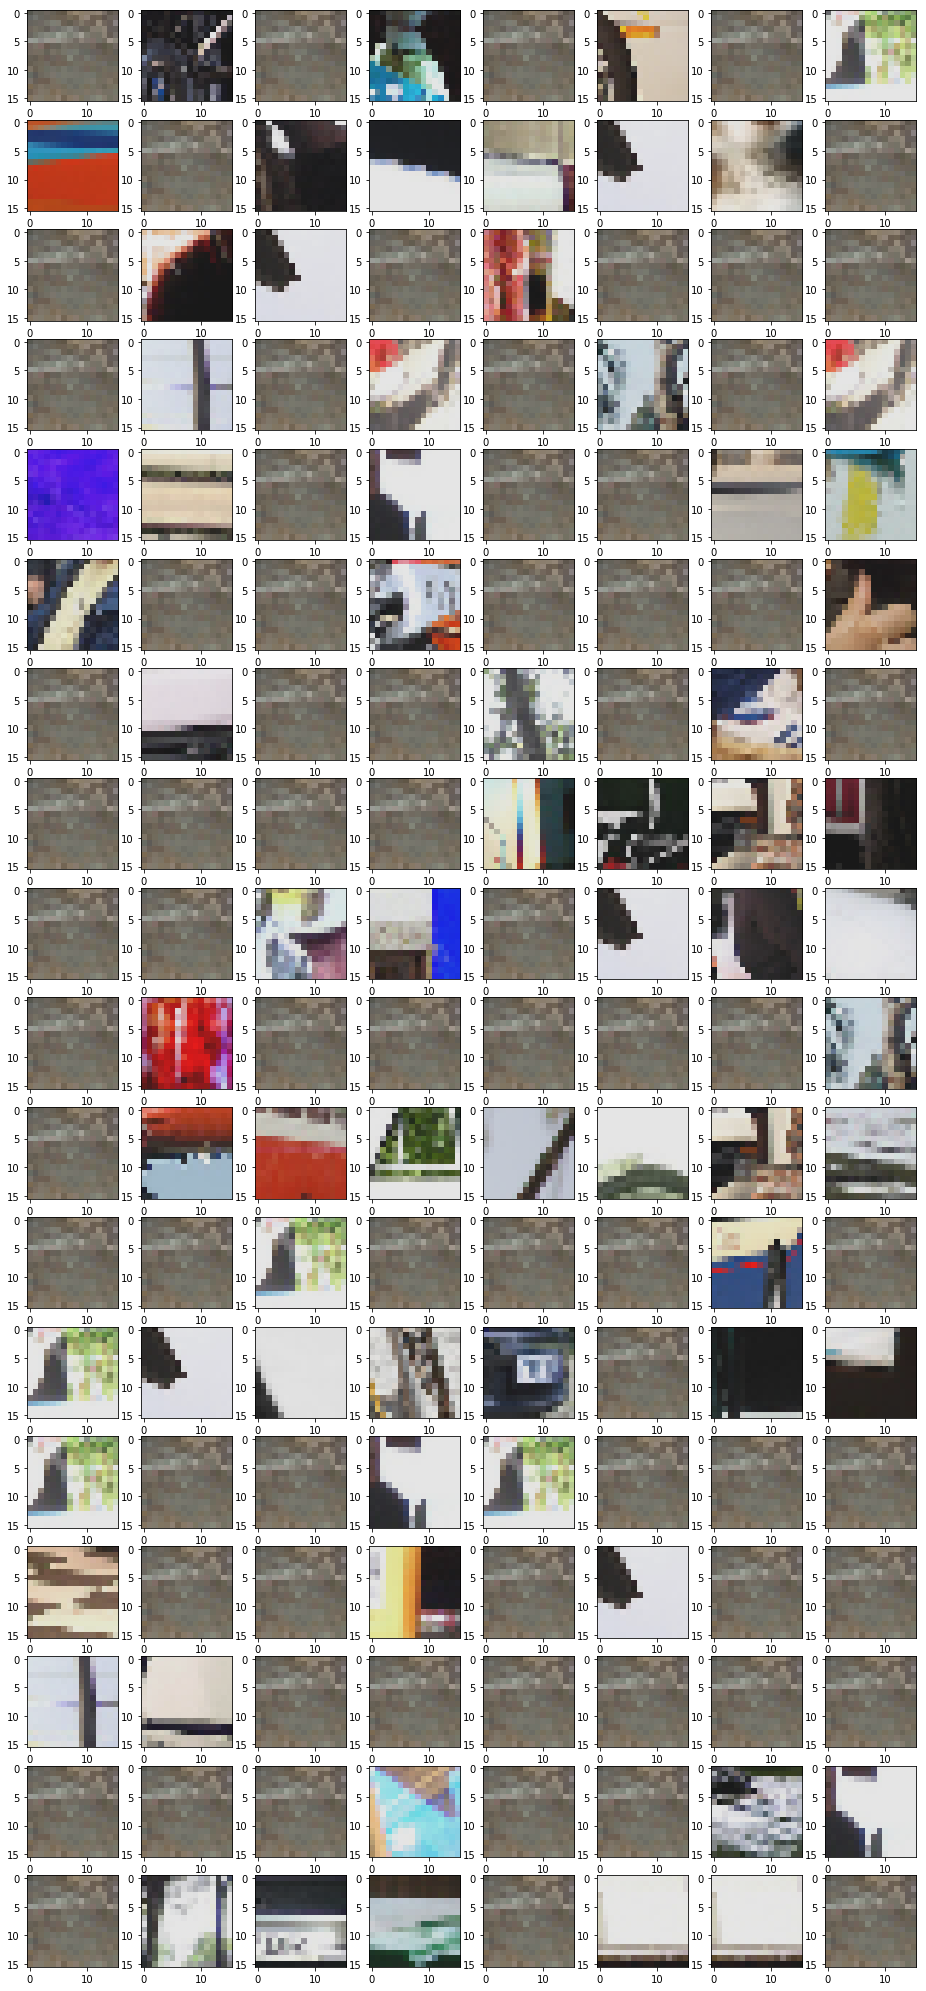

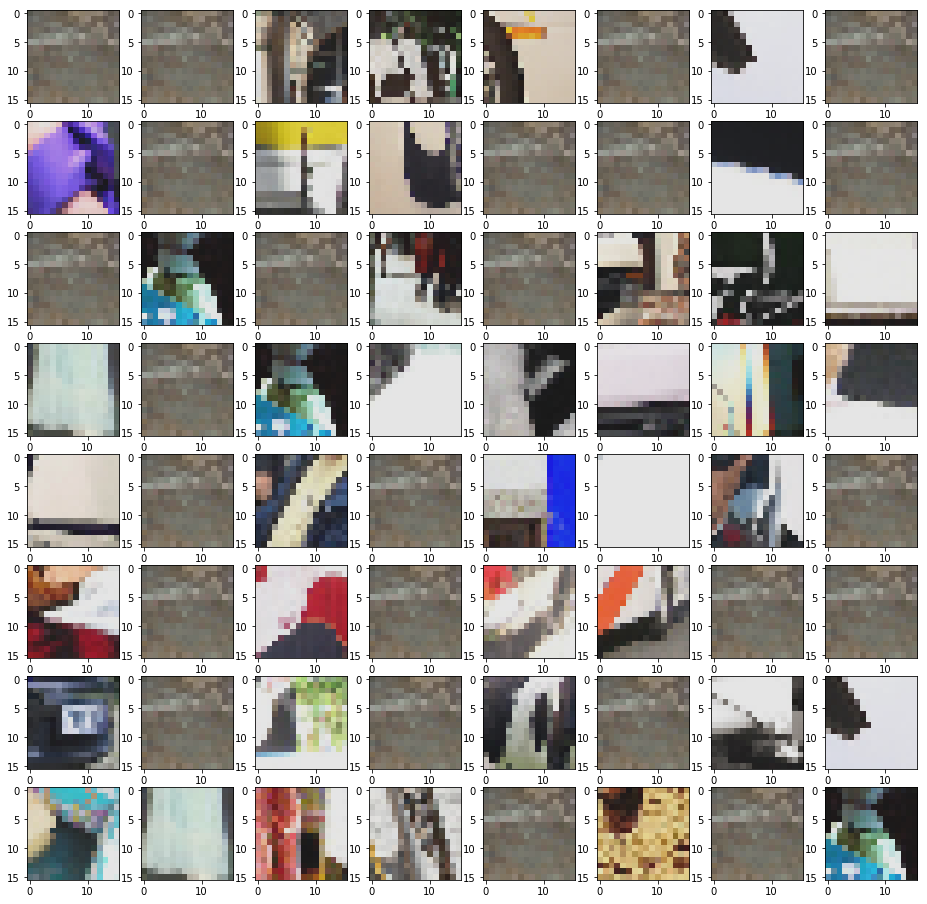

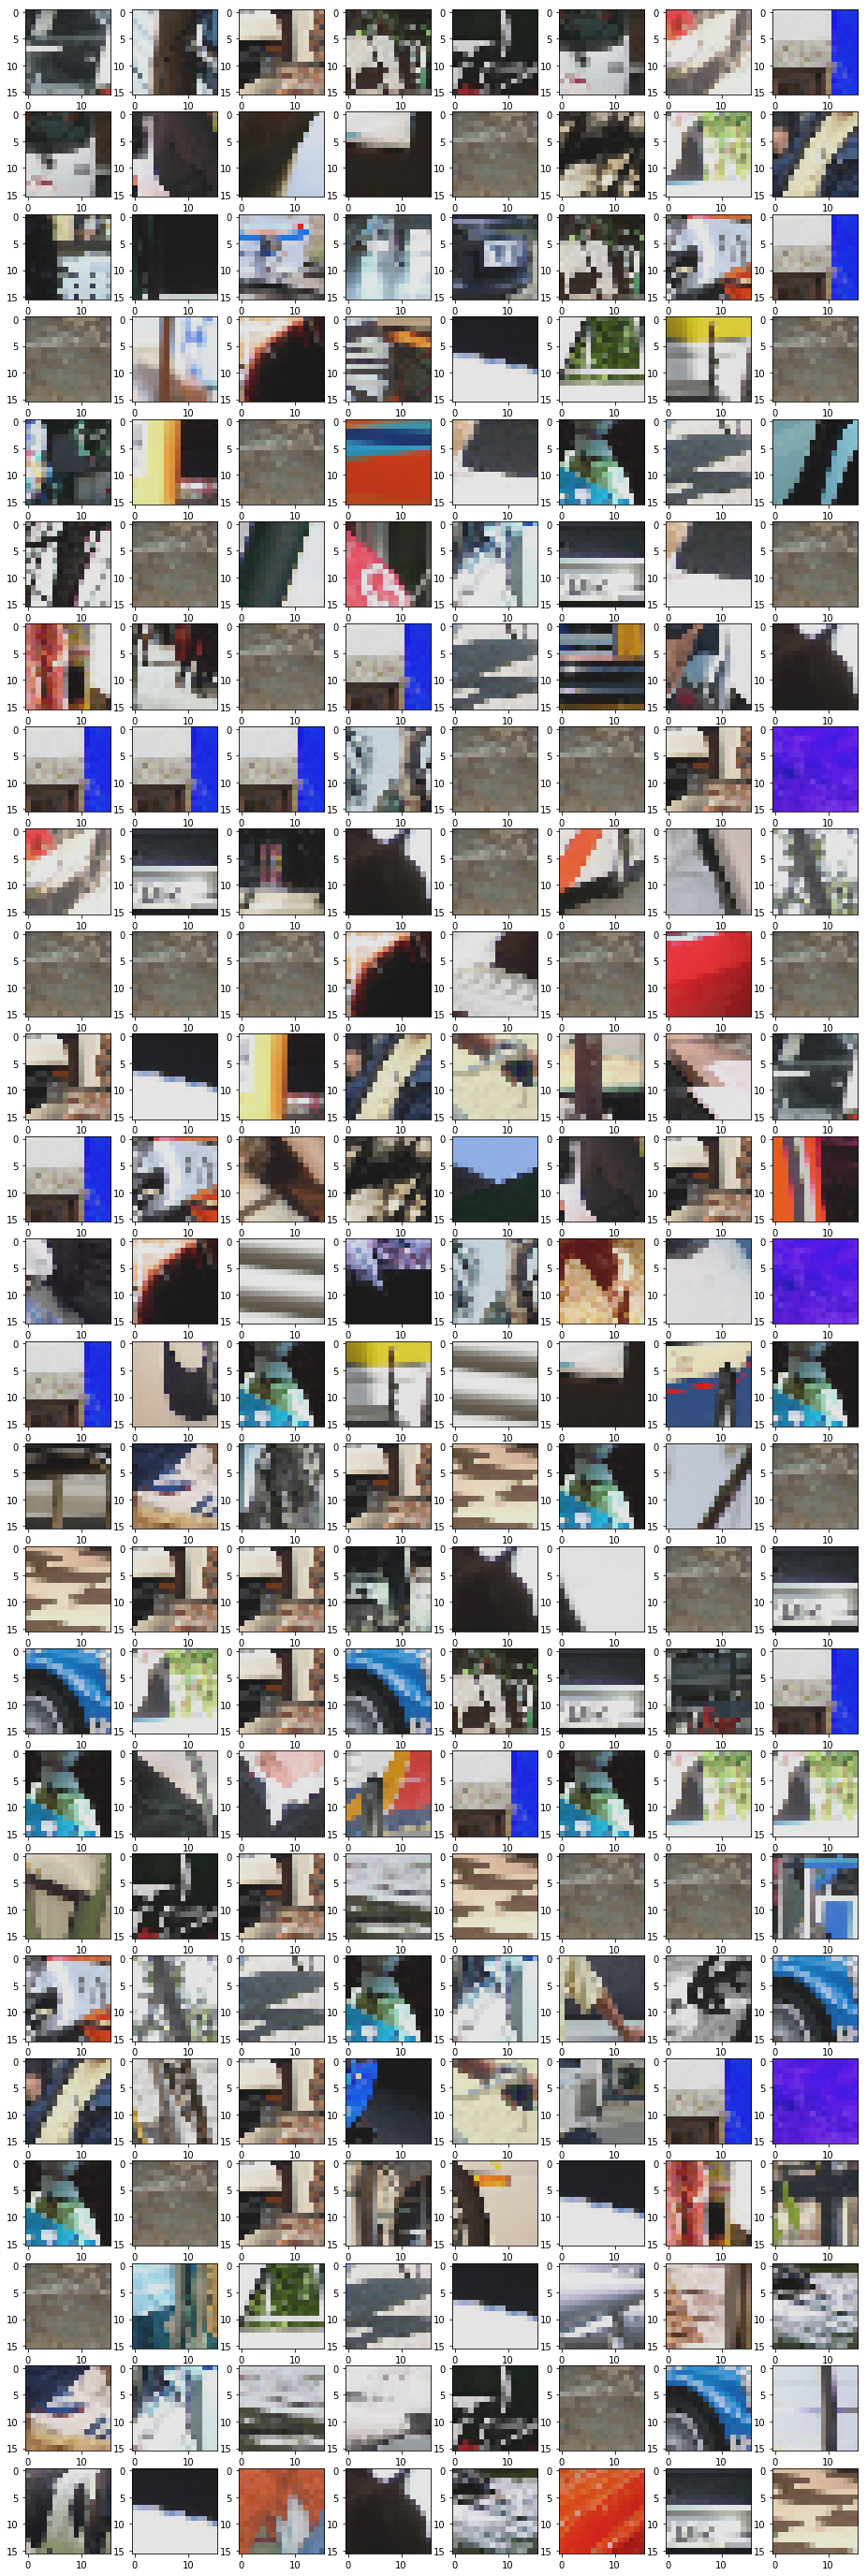

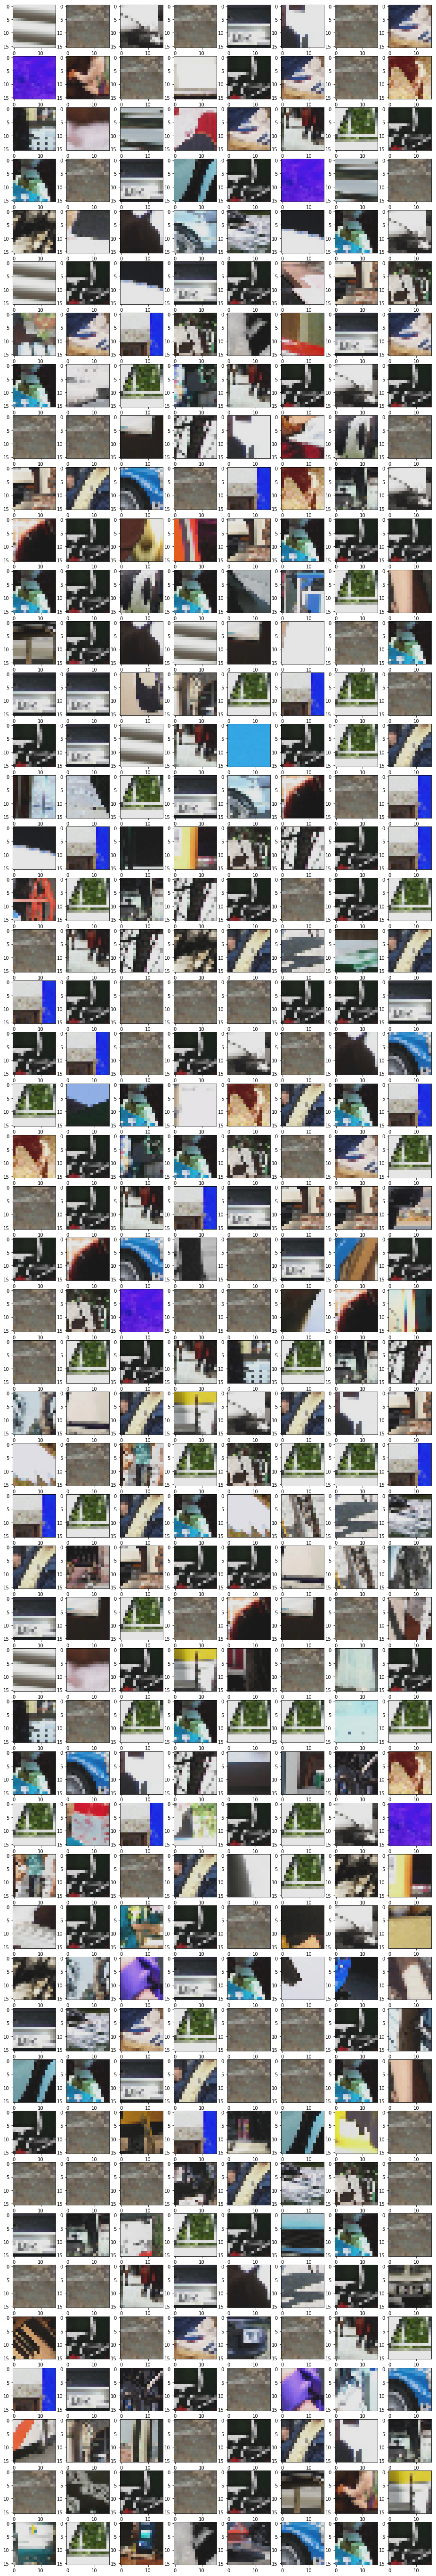

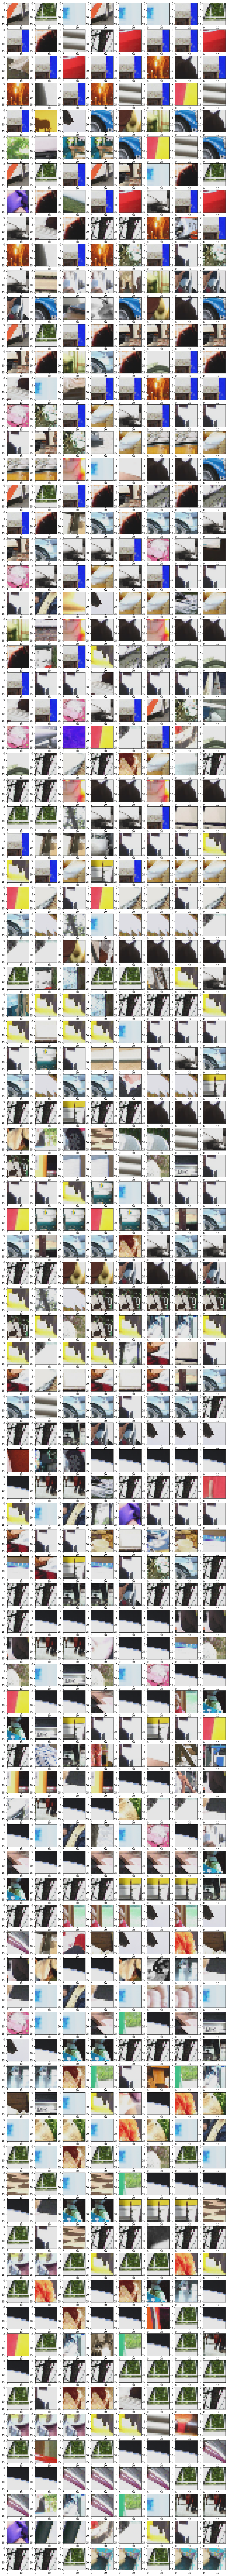

In [56]:
fig = plt.figure(figsize=(128, 128))
for i in range(1, len(autoencoder.layers)):
    show_pics(x_train[activations[i]].reshape(len(activations[i]),16,16,3), 8, len(activations[i])//8)

### Видно что от слоя к слою шаблоны на которые реагирую лучше всего нейроны усложняются.

### Исследование зависимости качества восстановления от параметров автоэнкодера (1 балл)


Обучите несколько автоэнкодеров с различным количеством слоёв, разными размерами bottleneck'a и сравните, насколько быстро модели обучаются и финальный лосс на валидационной выборке. Какие выводы вы можете сделать?

In [57]:
autoencoder1 = create_autoencoder_model(768, [768, 500, 300, 100], decoder_layer_shapes=[100, 300, 500])

Добавили слоев и нейронов. Посмотрим как изменится лосс.

In [59]:
autoencoder1.compile(loss='mean_squared_error',
              optimizer='adam')
hist = autoencoder1.fit(x_train, x_train,
          batch_size=100,
          epochs=150,
          validation_data=(x_test, x_test))

Train on 9000 samples, validate on 1000 samples
Epoch 1/150
9000/9000 [==============================] - 10s 1ms/step - loss: 0.0170 - val_loss: 0.0120
Epoch 2/150
9000/9000 [==============================] - 9s 970us/step - loss: 0.0119 - val_loss: 0.0118
Epoch 3/150
9000/9000 [==============================] - 9s 951us/step - loss: 0.0118 - val_loss: 0.0118
Epoch 4/150
9000/9000 [==============================] - 9s 948us/step - loss: 0.0117 - val_loss: 0.0118
Epoch 5/150
9000/9000 [==============================] - 8s 935us/step - loss: 0.0113 - val_loss: 0.0110
Epoch 6/150
9000/9000 [==============================] - 8s 864us/step - loss: 0.0108 - val_loss: 0.0106
Epoch 7/150
9000/9000 [==============================] - 8s 888us/step - loss: 0.0101 - val_loss: 0.0098
Epoch 8/150
9000/9000 [==============================] - 11s 1ms/step - loss: 0.0096 - val_loss: 0.0094
Epoch 9/150
9000/9000 [==============================] - 12s 1ms/step - loss: 0.0092 - val_loss: 0.0091
Epoch 10/1

In [60]:
score = autoencoder1.evaluate(x_test, x_test, verbose=0)
print('mse on validation:', score)

mse on validation: 0.00462439037487


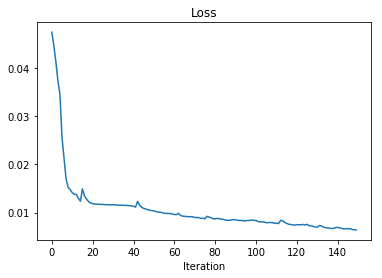

In [94]:
plt.title('Loss')
plt.xlabel('Iteration')
plt.plot(hist.history['loss'])

In [62]:
autoencoder2 = create_autoencoder_model(768, [500, 300, 200, 100, 50, 30], decoder_layer_shapes=[50, 200, 300, 500])

In [63]:
autoencoder2.compile(loss='mean_squared_error',
              optimizer='adam')
hist = autoencoder2.fit(x_train, x_train,
          batch_size=100,
          epochs=150,
          validation_data=(x_test, x_test))

Train on 9000 samples, validate on 1000 samples
Epoch 1/150
9000/9000 [==============================] - 8s 877us/step - loss: 0.0309 - val_loss: 0.0182
Epoch 2/150
9000/9000 [==============================] - 7s 764us/step - loss: 0.0175 - val_loss: 0.0170
Epoch 3/150
9000/9000 [==============================] - 7s 786us/step - loss: 0.0170 - val_loss: 0.0170
Epoch 4/150
9000/9000 [==============================] - 6s 689us/step - loss: 0.0155 - val_loss: 0.0143
Epoch 5/150
9000/9000 [==============================] - 6s 612us/step - loss: 0.0133 - val_loss: 0.0122
Epoch 6/150
9000/9000 [==============================] - 6s 680us/step - loss: 0.0119 - val_loss: 0.0120
Epoch 7/150
9000/9000 [==============================] - 6s 628us/step - loss: 0.0118 - val_loss: 0.0118
Epoch 8/150
9000/9000 [==============================] - 5s 514us/step - loss: 0.0117 - val_loss: 0.0119
Epoch 9/150
9000/9000 [==============================] - 7s 746us/step - loss: 0.0118 - val_loss: 0.0119
Epoch 1

In [66]:
score = autoencoder2.evaluate(x_test, x_test, verbose=0)
print('mse on validation:', score)

mse on validation: 0.00636663496494


In [64]:
autoencoder3 = create_autoencoder_model(768, [400, 100], decoder_layer_shapes=[300])

In [65]:
autoencoder3.compile(loss='mean_squared_error',
              optimizer='adam')
hist = autoencoder3.fit(x_train, x_train,
          batch_size=100,
          epochs=150,
          validation_data=(x_test, x_test))

Train on 9000 samples, validate on 1000 samples
Epoch 1/150
9000/9000 [==============================] - 4s 404us/step - loss: 0.0355 - val_loss: 0.0231
Epoch 2/150
9000/9000 [==============================] - 2s 232us/step - loss: 0.0145 - val_loss: 0.0119
Epoch 3/150
9000/9000 [==============================] - 2s 241us/step - loss: 0.0103 - val_loss: 0.0098
Epoch 4/150
9000/9000 [==============================] - 2s 234us/step - loss: 0.0093 - val_loss: 0.0092
Epoch 5/150
9000/9000 [==============================] - 2s 240us/step - loss: 0.0088 - val_loss: 0.0089
Epoch 6/150
9000/9000 [==============================] - 5s 525us/step - loss: 0.0080 - val_loss: 0.0079
Epoch 7/150
9000/9000 [==============================] - 3s 316us/step - loss: 0.0077 - val_loss: 0.0076
Epoch 8/150
9000/9000 [==============================] - 5s 544us/step - loss: 0.0076 - val_loss: 0.0074
Epoch 9/150
9000/9000 [==============================] - 3s 280us/step - loss: 0.0071 - val_loss: 0.0073
Epoch 1

In [67]:
score = autoencoder3.evaluate(x_test, x_test, verbose=0)
print('mse on validation:', score)

mse on validation: 0.003885567002


### Лучший скор дал автоэнкодер с меньшим числом слоев
### Автоэнкодер с большим числом слоев и более широким bottleneck'ом дал скор лучше самого первого автоэнкодера и даже приблизился по скору к автоэнкодеру с двумя слоями энкодера
### Автоэнкодер с большим числом слоев и более узким bottleneck'ом дал лучший скор чем самый первый энкодер

# Классификация MNIST и CIFAR (3,5 балла)

### MNIST (2 балла)

Загрузите датасет MNIST и провизуализируйте несколько цифр.

In [9]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

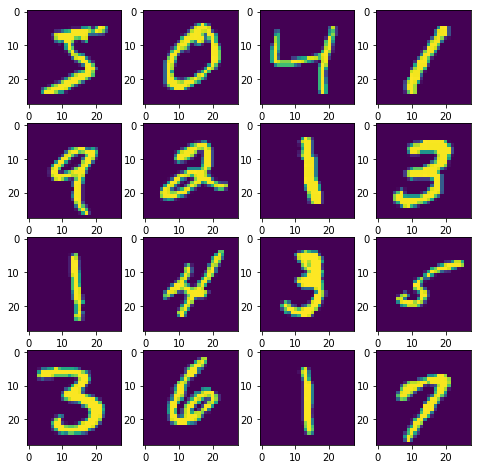

In [12]:
show_pics(x_train, 4, 4)

Сожмите данные автокодировщиком, у которого только один скрытый слой(по сути только bottleneck) с 30 нейронами.

In [13]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


In [14]:
x_train.shape[1]

784

In [17]:
input_img = Input(shape=(x_train.shape[1],))
encoded = Dense(30, activation='relu')(input_img)
decoded = Dense(x_train.shape[1], activation='sigmoid')(encoded)
model1 = Model(input_img, decoded)

In [18]:
model1.compile(loss='mean_squared_error',
              optimizer='adam')

In [19]:
mnist_hist = model1.fit(x_train, x_train,
          batch_size=300,
          epochs=100,
          validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 1s 22us/step - loss: 0.0740 - val_loss: 0.0444
Epoch 2/100
60000/60000 [==============================] - 1s 20us/step - loss: 0.0377 - val_loss: 0.0319
Epoch 3/100
60000/60000 [==============================] - 1s 20us/step - loss: 0.0290 - val_loss: 0.0258
Epoch 4/100
60000/60000 [==============================] - 1s 22us/step - loss: 0.0241 - val_loss: 0.0219
Epoch 5/100
60000/60000 [==============================] - 1s 23us/step - loss: 0.0208 - val_loss: 0.0191
Epoch 6/100
60000/60000 [==============================] - 1s 24us/step - loss: 0.0184 - val_loss: 0.0171
Epoch 7/100
60000/60000 [==============================] - 1s 20us/step - loss: 0.0166 - val_loss: 0.0155
Epoch 8/100
60000/60000 [==============================] - 1s 21us/step - loss: 0.0152 - val_loss: 0.0143
Epoch 9/100
60000/60000 [==============================] - 1s 22us/step - loss: 0.0142 - val_loss: 0.0

Возьмите несколько моделей из sklearn (KNN,SVM, RandomForest, GradientBoosting/XGBClassifier) и обучите модель со стандартными параметрами на выходах энкодера. Какие у вас получились результаты(точность) на тесте?

In [27]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier

In [28]:
knc = KNeighborsClassifier()
rfc = RandomForestClassifier()
gbc = GradientBoostingClassifier()
svc = SVC()

In [22]:
model1.layers

In [23]:
intermediate_layer_model1 = Model(inputs=model1.input,
                                 outputs=model1.layers[1].output)
intermediate_output1 = intermediate_layer_model1.predict(x_train)

In [24]:
intermediate_output2 = intermediate_layer_model1.predict(x_test)

In [25]:
intermediate_output1.shape

(60000, 30)

### KNC

In [26]:
knc.fit(intermediate_output1, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [27]:
x_pred = knc.predict(intermediate_output2)

In [28]:
np.mean(x_pred == y_test)

0.96740000000000004

### SVC

In [29]:
svc.fit(intermediate_output1, y_train)
x_pred = svc.predict(intermediate_output2)
np.mean(x_pred == y_test)

0.82550000000000001

### RandomForest 

In [30]:
rfc.fit(intermediate_output1, y_train)
x_pred = rfc.predict(intermediate_output2)
np.mean(x_pred == y_test)

0.90349999999999997

### Gradient Boosting

In [31]:
gbc.fit(intermediate_output1, y_train)
x_pred = gbc.predict(intermediate_output2)
np.mean(x_pred == y_test)

0.91449999999999998

### CIFAR10(2 балла)

Загрузите CIFAR10 и обучите автоэнкодер на случайных сэмплах размера 8x8 из этого датасета. Архитектура автоэнкодера как в прошлом пункте - только один внутренний слой из 30 нейронов.

In [4]:
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [9]:
x_train_cut = get_samples(x_train, len(x_train), 8)
x_test_cut = get_samples(x_test, len(x_test), 8)

In [10]:
x_train_cut = x_train_cut.astype('float32') / 255.
x_test_cut = x_test_cut.astype('float32') / 255.
x_train_new = x_train_cut.reshape((len(x_train_cut), np.prod(x_train_cut.shape[1:])))
x_test_new = x_test_cut.reshape((len(x_test_cut), np.prod(x_test_cut.shape[1:])))
print(x_train_new.shape)
print(x_test_new.shape)

(50000, 192)
(10000, 192)


In [11]:
input_img = Input(shape=(x_train_new.shape[1],))
encoded = Dense(30, activation='relu')(input_img)
decoded = Dense(x_train_new.shape[1], activation='sigmoid')(encoded)
model2 = Model(input_img, decoded)

In [12]:
model2.compile(loss='mean_squared_error',
              optimizer='adam')

In [13]:
mnist_hist = model2.fit(x_train_new, x_train_new,
          batch_size=32,
          epochs=100,
          validation_data=(x_test_new, x_test_new))

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 2s 34us/step - loss: 0.0140 - val_loss: 0.0052
Epoch 2/100
50000/50000 [==============================] - 2s 31us/step - loss: 0.0043 - val_loss: 0.0037
Epoch 3/100
50000/50000 [==============================] - 2s 31us/step - loss: 0.0035 - val_loss: 0.0033
Epoch 4/100
50000/50000 [==============================] - 2s 30us/step - loss: 0.0032 - val_loss: 0.0031
Epoch 5/100
50000/50000 [==============================] - 2s 31us/step - loss: 0.0030 - val_loss: 0.0032
Epoch 6/100
50000/50000 [==============================] - 2s 31us/step - loss: 0.0029 - val_loss: 0.0028
Epoch 7/100
50000/50000 [==============================] - 2s 31us/step - loss: 0.0027 - val_loss: 0.0027
Epoch 8/100
50000/50000 [==============================] - 2s 30us/step - loss: 0.0027 - val_loss: 0.0026
Epoch 9/100
50000/50000 [==============================] - 2s 31us/step - loss: 0.0026 - val_loss: 0.0

Теперь разделите каждую картинку из датасета на 16 сэмплjd размера 8x8, закодируйте их через энкодер и склейте 16 выходов энкодера в один вектор. Каждый объект в итоге должен кодироваться 16 * 30 = 380 признаками.

In [14]:
def cut_pic(arr):
    res = np.zeros((len(arr)*16, 8, 8, 3))
    for i in range(0, len(arr)):
        for j in range(0, 4):
            for k in range(0, 4):
                res[i*16 + k + j*4] = arr[i, (8*j):(8*j + 8), (8*k):(8*k + 8)]
    return res/255.

In [15]:
x_train_cut = cut_pic(x_train)

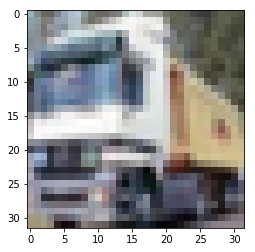

In [62]:
plt.imshow(x_train[1])

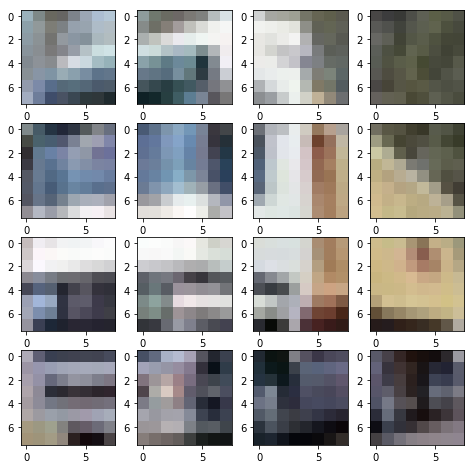

In [63]:
show_pics(x_train_cut[16:32], 4, 4)

In [16]:
x_train_cut = x_train_cut.reshape((len(x_train_cut), np.prod(x_train_cut.shape[1:])))

In [17]:
encoder1 = Model(inputs=model2.input,
                                 outputs=model2.layers[1].output)
encoder1_output = encoder1.predict(x_train_cut)

In [18]:
encoder1_output.shape

(800000, 30)

In [19]:
x_train_1 = np.zeros((len(x_train), 16*30))
for i in range(0, len(x_train)):
    x_train_1[i] = encoder1_output[i*16:(i+1)*16].reshape(1, 16*30)
x_train_1.shape

(50000, 480)

In [20]:
x_test_cut = cut_pic(x_test)
x_test_cut = x_test_cut.reshape((len(x_test_cut), np.prod(x_test_cut.shape[1:])))
encoder1_output_test = encoder1.predict(x_test_cut)

x_test_1 = np.zeros((len(x_test), 16*30))
for i in range(0, len(x_test)):
    x_test_1[i] = encoder1_output_test[i*16:(i+1)*16].reshape(1, 16*30)
x_test_1.shape

(10000, 480)

Теперь обучите SVM на преобразованных объектах и выведите точность.

In [25]:
y_train = y_train.reshape((len(y_train),))
y_test = y_test.reshape((len(y_test),))

In [29]:
svc.fit(x_train_1, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [30]:
x_pred = svc.predict(x_test_1)
np.mean(x_pred == y_test)

0.50780000000000003